# Task 1
This implementation of image recoloring using a CNN was based on [this notebook](https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/colorization.ipynb) that was recommended on the task's description.

 ### Setup
 We start by importing all libraries that we might need such as torch and tourchvision to import, load and process data, skimage,PIL, etc.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from skimage import color
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# from PIL import Image
from torchsummary import summary
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Let's also select the best available device (gpu or cpu) and define some inicial parameters for training

In [2]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
num_epochs = 1
batch_size = 512
learning_rate = 1e-3
num_workers = 2 # how many processes are used to load the data

Using cuda device


### Data Loading
As sugested both in the task description and the reference notebook we are going to use the CIFAR-10 dataset for simplicity and to then continue with the same data for task 2.

It is a standard import using torch and we only need to convert the image from the rgb color space to Lab. This new color space has a Lightness channel __L__ we will be feeding as input and 2 Hue channels __a__ and __b__ (from green to magenta, and from blue to yellow respectively) that we want the network to predict.

In [3]:
# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
data_aug = transforms.Compose([
    transforms.Lambda(import_image)
  ])

training_data = datasets.CIFAR10(
    root="./data/CIFAR10",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.CIFAR10(
    root="./data/CIFAR10",
    train=False,
    download=True,
    transform=data_aug,
)
print(f"Training size: {len(training_data)} \nValidation size: {len(validation_data)}")

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified
Training size: 50000 
Validation size: 10000


In [29]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        intermediateFeatures = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(intermediateFeatures)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x, intermediateFeatures

cnet = ColorNet()
cnet = cnet.to(device)



num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 773698


In [30]:
summary(cnet,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             544
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          32,832
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]         131,200
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 128, 4, 4]         147,584
       BatchNorm2d-8            [-1, 128, 4, 4]             256
            Conv2d-9            [-1, 128, 4, 4]         147,584
      BatchNorm2d-10            [-1, 128, 4, 4]             256
           Conv2d-11            [-1, 128, 4, 4]         147,584
      BatchNorm2d-12            [-1, 128, 4, 4]             256
  ConvTranspose2d-13             [-1, 64, 8, 8]         131,136
      BatchNorm2d-14             [-1, 6

# LOAD MODEL IF AVALIABLE

In [34]:
# Save model
inp = input()
inp = inp.split()[0].split(".")[0]
if(inp!=""):
    cnet.load_state_dict(torch.load("./data/pretrained/"+inp+".pth"))
else:
    print("Invalid file name")

# Or train a new one

In [32]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

# set to training mode
cnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for lab_batch, _ in train_dataloader:
        
        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch,_ = cnet(lab_batch[:, 0:1, :, :])
        
        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))



Training ...
Epoch [1 / 10] average reconstruction error: 172.580604
Epoch [2 / 10] average reconstruction error: 154.384191
Epoch [3 / 10] average reconstruction error: 149.386244
Epoch [4 / 10] average reconstruction error: 145.559412
Epoch [5 / 10] average reconstruction error: 141.805721
Epoch [6 / 10] average reconstruction error: 137.745252
Epoch [7 / 10] average reconstruction error: 132.744889
Epoch [8 / 10] average reconstruction error: 126.429597
Epoch [9 / 10] average reconstruction error: 120.593824
Epoch [10 / 10] average reconstruction error: 114.561236


10
114.56123570033482


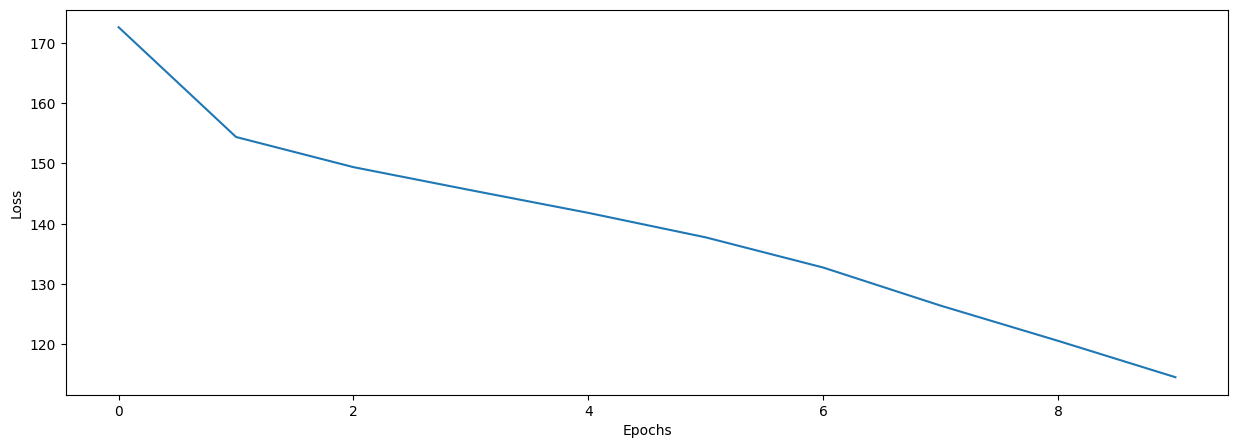

In [33]:
print(len(train_loss_avg))
print(train_loss_avg[-1])
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [37]:
# set to evaluation mode
cnet.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in validation_dataloader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch,_ = cnet(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 187.261079


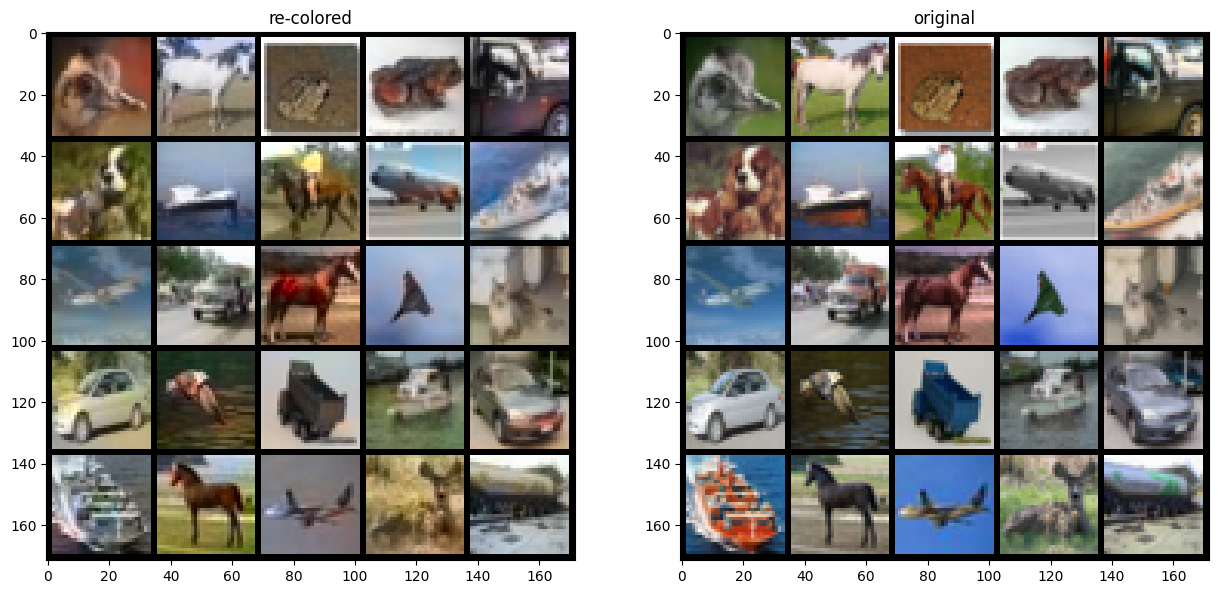

In [39]:
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(validation_data), 25, replace=False)
    lab_batch = torch.stack([validation_data[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch,_ = cnet(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()


In [ ]:
# Save model
inp = input()
inp = inp.split()[0].split(".")[0]
if(inp!=""):
    torch.save(cnet.state_dict(), "./data/pretrained/"+inp+".pth")
else:
    print("Invalid file name")


# Task 2

In [60]:
# Define your SSL classification model
class SSLClassifier(nn.Module):
    def __init__(self, colorization_model, num_classes):
        super(SSLClassifier, self).__init__()
        self.colorization_model = colorization_model
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        

        # Additional layers for classification on top of the colorization model
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        _,features = self.colorization_model(x[:, 0:1, :, :])
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        new_x = torch.cat((x,features),1)
        return self.layers(new_x)

In [61]:
# Create your SSL classifier model
num_classes = 10  # Number of classes in CIFAR-10
ssl_model = SSLClassifier(cnet, num_classes)
ssl_model.to(device)
criterion = nn.CrossEntropyLoss()  # Define the appropriate loss function for classification
optimizer = torch.optim.Adam(ssl_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation


In [62]:
summary(ssl_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             544
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          32,832
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]         131,200
       BatchNorm2d-6            [-1, 128, 4, 4]             256
            Conv2d-7            [-1, 128, 4, 4]         147,584
       BatchNorm2d-8            [-1, 128, 4, 4]             256
            Conv2d-9            [-1, 128, 4, 4]         147,584
      BatchNorm2d-10            [-1, 128, 4, 4]             256
           Conv2d-11            [-1, 128, 4, 4]         147,584
      BatchNorm2d-12            [-1, 128, 4, 4]             256
  ConvTranspose2d-13             [-1, 64, 8, 8]         131,136
      BatchNorm2d-14             [-1, 6

In [63]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
        for lab_batch, y in tqdm(train_dataloader):
            y = y.to(device)
            lab_batch = lab_batch.to(device)

            # Compute prediction error
            pred = model(lab_batch)
            loss = loss_fn(pred, y)

            if is_train:
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Save training metrics
            total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

            probs = F.softmax(pred, dim=1)
            final_pred = torch.argmax(probs, dim=1)
            preds.extend(final_pred.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [64]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, ssl_model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, ssl_model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': ssl_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': ssl_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Train loss: 1.585 	 Train acc: 0.415


100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Val loss: 6.224 	 Val acc: 0.536

Epoch 2


100%|██████████| 98/98 [00:36<00:00,  2.70it/s]


Train loss: 1.295 	 Train acc: 0.530


100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Val loss: 5.567 	 Val acc: 0.586

Epoch 3


100%|██████████| 98/98 [00:48<00:00,  2.04it/s]


Train loss: 1.170 	 Train acc: 0.580


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Val loss: 5.135 	 Val acc: 0.621

Epoch 4


100%|██████████| 98/98 [00:42<00:00,  2.29it/s]


Train loss: 1.080 	 Train acc: 0.617


100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Val loss: 4.363 	 Val acc: 0.687

Epoch 5


100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Train loss: 1.011 	 Train acc: 0.641


100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Val loss: 4.062 	 Val acc: 0.707

Epoch 6


100%|██████████| 98/98 [00:45<00:00,  2.16it/s]


Train loss: 0.948 	 Train acc: 0.665


100%|██████████| 98/98 [00:48<00:00,  2.02it/s]


Val loss: 4.184 	 Val acc: 0.692

Epoch 7


100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


Train loss: 0.895 	 Train acc: 0.685


100%|██████████| 98/98 [00:46<00:00,  2.11it/s]


Val loss: 3.650 	 Val acc: 0.735

Epoch 8


100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Train loss: 0.854 	 Train acc: 0.700


100%|██████████| 98/98 [00:47<00:00,  2.08it/s]


Val loss: 3.174 	 Val acc: 0.776

Epoch 9


100%|██████████| 98/98 [00:51<00:00,  1.90it/s]


Train loss: 0.812 	 Train acc: 0.713


100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


Val loss: 2.974 	 Val acc: 0.788

Epoch 10


100%|██████████| 98/98 [00:49<00:00,  2.00it/s]


Train loss: 0.777 	 Train acc: 0.724


100%|██████████| 98/98 [00:47<00:00,  2.05it/s]

Val loss: 2.829 	 Val acc: 0.804
Finished


In [65]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

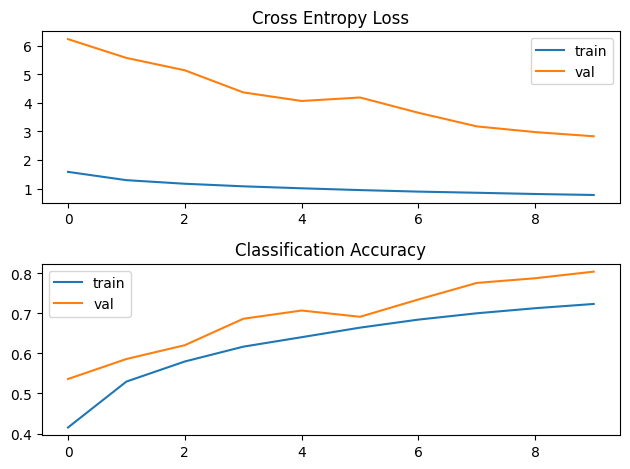

In [66]:
plotTrainingHistory(train_history, val_history)

In [ ]:
# Evaluate the model in the test set

# load the best model (i.e. model with the lowest val loss...might not be the last model)
# we could also load the optimizer and resume training if needed

# model = ssl_model.to(device)
# checkpoint = torch.load('best_model.pth')
# model.load_state_dict(checkpoint['model'])

# test_loss, test_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
# print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

In [67]:
def showErrors(model, dataloader, num_examples=20):    
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, classes[y[0].item()], fontsize=14, color='green') # correct
      plt.text(-1, 8, classes[final_pred[0].item()], fontsize=14, color='red')  # predicted
      x,y,z = X[0].cpu()
      res = [ [0]*32 for i in range(32)]
      for i in range(32):
         for j in range(32):
            res[i][j] = [x[i,j],y[i,j],z[i,j]]
            res[i][j] = color.lab2rgb(res[i][j])
      plt.imshow(res)
    plt.show()

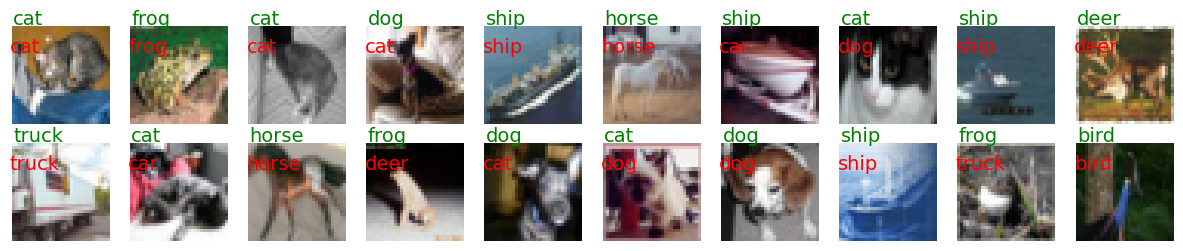

In [69]:
showErrors(ssl_model, validation_dataloader)